<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#DAG-(направленный-ациклический-граф)" data-toc-modified-id="DAG-(направленный-ациклический-граф)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DAG (направленный ациклический граф)</a></span></li></ul></div>

# Описание данных

Набор данных о видеоиграх, объем продаж которых составил более 100 000 копий.

Имеются следующие поля:

- *Rank* – место по объему продаж
- *Name* – название игры
- *Platform* – платформа, на которой выпущена игра
- *Year* – год релиза
- *Genre* – жанр
- *Publisher* – издатель
- *NA_Sales* – продажи в Северной Америке, в млн.
- *EU_Sales* – продажи в Европе, в млн.
- *JP_Sales* – продажи в Японии, в млн.
- *Other_Sales* – продажи в остальном мире, в млн.
- *Global_Sales* – продажи по всему миру, в млн.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('vgsales.csv')

display(df.sample(n=7, random_state=42))  # Случайные 7 строк таблицы

display(df.shape)  # Размеры таблицы

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
8928,8930,F1 2012,PC,2012.0,Racing,Codemasters,0.01,0.11,0.00,0.03,0.15
4789,4791,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",PS3,2007.0,Action,Activision,0.32,0.04,0.01,0.04,0.40
15492,15495,Commandos 3: Destination Berlin,PC,2003.0,Strategy,Eidos Interactive,0.00,0.02,0.00,0.00,0.02
14767,14770,The Sims 2: Bon Voyage,PC,2007.0,Simulation,Electronic Arts,0.01,0.01,0.00,0.00,0.03
5211,5213,Guitar Hero: Smash Hits,PS3,2009.0,Misc,Activision,0.20,0.11,0.00,0.05,0.36
720,722,Sonic Advance,GBA,2001.0,Platform,Sega,1.19,0.71,0.22,0.13,2.24
4918,4920,Red Faction: Armageddon,X360,2011.0,Shooter,THQ,0.18,0.17,0.01,0.04,0.39


(16598, 11)

# DAG (направленный ациклический граф)

Данный dag приводит ответы на следующие вопросы:

*1) Какая игра была самой продаваемой в этом году во всем мире?  
2) Игры какого жанра были самыми продаваемыми в Европе? Перечислить все, если их несколько  
3) На какой платформе было больше всего игр, которые продались более чем миллионным тиражом в Северной Америке?  
4) Перечислить все, если их несколько  
5) У какого издателя самые высокие средние продажи в Японии?  
6) Перечислить все, если их несколько  
7) Сколько игр продались лучше в Европе, чем в Японии?*

In [ ]:
# DAG в парадигме Airflow 2.0

# Импорт нужных для работы библиотек
import requests
import json
from urllib.parse import urlencode

import pandas as pd
import numpy as np

from datetime import timedelta
from datetime import datetime
import telegram

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context
from airflow.models import Variable


LINK_FOR_DF = 'vgsales.csv'  # Данные
YEAR_FOR_ANALYSIS = 2011  # Год для анализа


default_args = {
    'owner': 'r.shokalo',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2022, 7, 7)
}

schedule_interval = '*/5 11 * * *'  # Расписание: каждый день в каждую 5 минуту с 11ч до 12ч дня


# Взаимодействие с telegram
def our_telegram_api(my_message):
    
    token = '5375665808:AAE4hypsZh0bI7W1kHLGg4Yl4J5cJzUaTbg'  # Токен для моего телеграм бота
    chat_id = -655053148  # Чат id для чата со мной и моим телеграм ботом
    
    message = my_message  # Фраза в случае, если dag успешен
    
    params = {'chat_id': chat_id, 'text': message}
    
    base_url = f'https://api.telegram.org/bot{token}/'
    url = base_url + 'sendMessage?' + urlencode(params)
    
    resp = requests.get(url)
    
    
def success_message(context):
    date = context['ds']
    dag_id = context['dag'].dag_id
    our_telegram_api(f'Successfully done! Dag {dag_id} completed on {date}')
    
    
def failure_message(context):
    date = context['ds']
    dag_id = context['dag'].dag_id
    our_telegram_api(f'Something gone wrong! Dag {dag_id} failed on {date}')


@dag(default_args=default_args, catchup=False, schedule_interval=schedule_interval)
def rshokalo_dag():
    # Таск 1: Получаем данные
    @task(retries=5)
    def get_data():
        df = pd.read_csv(LINK_FOR_DF)
        df_games = df[df['Year'] == YEAR_FOR_ANALYSIS]
        return df_games
    
    # Таск 2: Какая игра была самой продаваемой в этом году во всем мире?
    @task()
    def get_best_selling_game(df_games):
        best_selling_game = df_games[df_games['Global_Sales'] == df_games['Global_Sales'].max()]['Name'].to_list()
        return best_selling_game
    
        
    # Таск 3: Игры какого жанра были самыми продаваемыми в Европе? Перечислить все, если их несколько (если продажи игр равны)
    @task()
    def get_best_selling_genre_eu(df_games):
        best_selling_genre_eu = df_games.nlargest(1, 'EU_Sales', keep='all')['Genre'].unique().tolist()
        return best_selling_genre_eu
    
    # Таск 4: На какой платформе было больше всего игр, которые продались более чем миллионным тиражом в Северной Америке? 
    # Перечислить все, если их несколько
    @task()
    def get_top_platforms_na(df_games):
        top_platforms_na = df_games \
                            .query('NA_Sales > 1') \
                            .groupby('Platform') \
                            .agg({'NA_Sales': 'count'}) \
                            ['NA_Sales'] \
                            .nlargest(1, keep='all') \
                            .index.to_list()
        return top_platforms_na
    
    # Таск 5: У какого издателя самые высокие средние продажи в Японии? Перечислить все, если их несколько
    @task()
    def get_top_mean_sales(df_games):
        top_mean_sales = df_games \
                            .groupby('Publisher', as_index=False) \
                            .agg({'JP_Sales': 'mean'}) \
                            .sort_values(by='JP_Sales', ascending=False) \
                            .round(2) \
                            .nlargest(1, 'JP_Sales', keep='all') \
                            ['Publisher'] \
                            .to_list()
        return top_mean_sales
    
    # Таск 6: Сколько игр продались лучше в Европе, чем в Японии?
    @task()
    def get_eu_sales_more_jp(df_games):
        eu_sales_more_jp = df_games \
                            .groupby('Name') \
                            .agg({'EU_Sales': 'sum', 'JP_Sales': 'sum'}) \
                            .reset_index() \
                            .query('EU_Sales > JP_Sales') \
                            ['Name'] \
                            .count()
        return eu_sales_more_jp
    
    # Таск 7: Печатаем ответы на вопросы
    @task(on_success_callback=success_message, on_failure_callback=failure_message)
    def print_answers(best_selling_game,
                      best_selling_genre_eu,
                      top_platforms_na,
                      top_mean_sales,
                      eu_sales_more_jp,
                     ):
        
        context = get_current_context()
        date = context['ds']
        
        print(f'Данные по видеоиграм представлены для {YEAR_FOR_ANALYSIS} года')
        print(f'Самая продаваемая игра в мире: {best_selling_game}')
        print(f"Жанр, игры которого были самыми продаваемыми в Европе: {', '.join(best_selling_genre_eu)}")
        print(f"Платформа, на которой было больше всего игр, проданных более чем миллионным тиражом в Северной Америке: {', '.join(top_platforms_na)}")
        print(f"Издатель с самыми высокими средними продажами в Японии: {', '.join(top_mean_sales)}")
        print(f"Кол-во игр, которые продались лучше в Европе, чем в Японии: {eu_sales_more_jp}")
        
    df_games = get_data()
    
    best_selling_game = get_best_selling_game(df_games)
    best_selling_genre_eu = get_best_selling_genre_eu(df_games)
    top_platforms_na = get_top_platforms_na(df_games)
    top_mean_sales = get_top_mean_sales(df_games)
    eu_sales_more_jp = get_eu_sales_more_jp(df_games)
    
    print_answers(best_selling_game,
                  best_selling_genre_eu,
                  top_platforms_na,
                  top_mean_sales,
                  eu_sales_more_jp)
    
    
rshokalo_dag = rshokalo_dag()

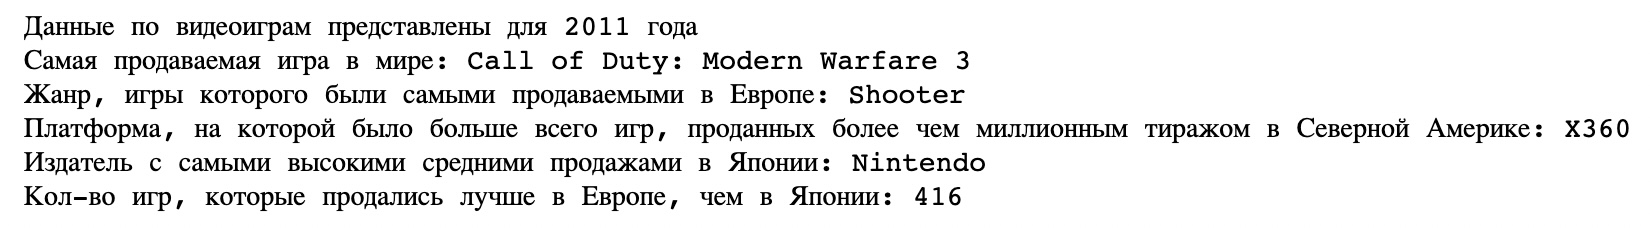